# Interpretive LSTM model for identifying shallow groundwater drought mechanisms

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
## Import libraries developed in this study
import Interpret_LSTM_GW_data as xdata
import Interpret_LSTM_GW_index as xutils
import Interpret_LSTM_GW_Int_methods as xinterpret
import Interpret_LSTM_GW_plot as xplot
from GWS_hydrodata_ALL import DataforIndividual
## Import dependent libraries
import os, logging, pickle
import numpy as np
import pandas as pd
import pastas as ps
import spi

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

## Ignore all the warnings
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_WARNINGS'] = '0'

plt.rcParams.update(plt.rcParamsDefault)

In [4]:

import pastas as ps
import matplotlib.pyplot as plt
import spi
import matplotlib.pylab as mpl
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.7.15 (default, Nov 24 2022, 18:44:54) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.6
Scipy version: 1.7.3
Pandas version: 1.3.5
Pastas version: 0.21.0
Matplotlib version: 3.5.3


In [5]:
WORKING_PATH  = r"C:\Users\e0427809\Desktop\Github\Dataset\GRACE"

####################
#   Basin set up   #
####################
STATION_ID = 'Georgia' # USGS code used in the MOPEX dataset

####################
#  Hyperparameters #
####################
RANDOM_SEED   = 100        
WRAP_LENGTH   = 180        # Timestep of the LSTM mode l
TRAIN_FRAC    = 0.7        # The fraction of spliting traning and testing dataset

LEARNING_RATE = 0.03
EPOCH_NUMBER  = 100

In [6]:
camels_path = os.path.join(WORKING_PATH, f'{STATION_ID}.csv')
data_path  = os.path.join(WORKING_PATH, 'data', f'{STATION_ID}_data.pickle')
model_path = os.path.join(WORKING_PATH, 'results', 'model', f'{STATION_ID}_{RANDOM_SEED}_keras.h5')
eg_path    = os.path.join(WORKING_PATH, 'results', 'eg',    f'{STATION_ID}_{RANDOM_SEED}_eg.pickle')

## 1. Prepare data

First, we load the downloaded CAMELS dataset for the station. 

In [7]:
hydrodata = xdata.get_station_data(fname=camels_path)

In [8]:
print(hydrodata)

#print(hydrodata['date'])

            Evapotranspiration  Groundwater storage  \
date                                                  
1980-01-01            0.000013           766.102539   
1980-01-02            0.000013           767.008423   
1980-01-03            0.000014           767.670959   
1980-01-04            0.000019           768.583801   
1980-01-05            0.000010           770.728333   
...                        ...                  ...   
2011-12-28            0.000017           675.710510   
2011-12-29            0.000014           679.279419   
2011-12-30            0.000013           681.504395   
2011-12-31            0.000016           682.916016   
2012-01-01            0.000018           683.940002   

            Near surface air temperature  Plant canopy  \
date                                                     
1980-01-01                    280.741913  4.580000e-06   
1980-01-02                    279.193024  8.190000e-07   
1980-01-03                    282.750122  2.050000e-

### Plot the data loaded for overview

In [9]:
print(hydrodata.index)

DatetimeIndex(['1980-01-01', '1980-01-02', '1980-01-03', '1980-01-04',
               '1980-01-05', '1980-01-06', '1980-01-07', '1980-01-08',
               '1980-01-09', '1980-01-10',
               ...
               '2011-12-23', '2011-12-24', '2011-12-25', '2011-12-26',
               '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30',
               '2011-12-31', '2012-01-01'],
              dtype='datetime64[ns]', name='date', length=11689, freq=None)


### Gerenate data pairs (x and y) for the given `WRAP_LENGTH`

In [10]:
GWS = hydrodata['Groundwater storage']
prcp = hydrodata['Total precipitation rate']
Tmean = hydrodata['Near surface air temperature']

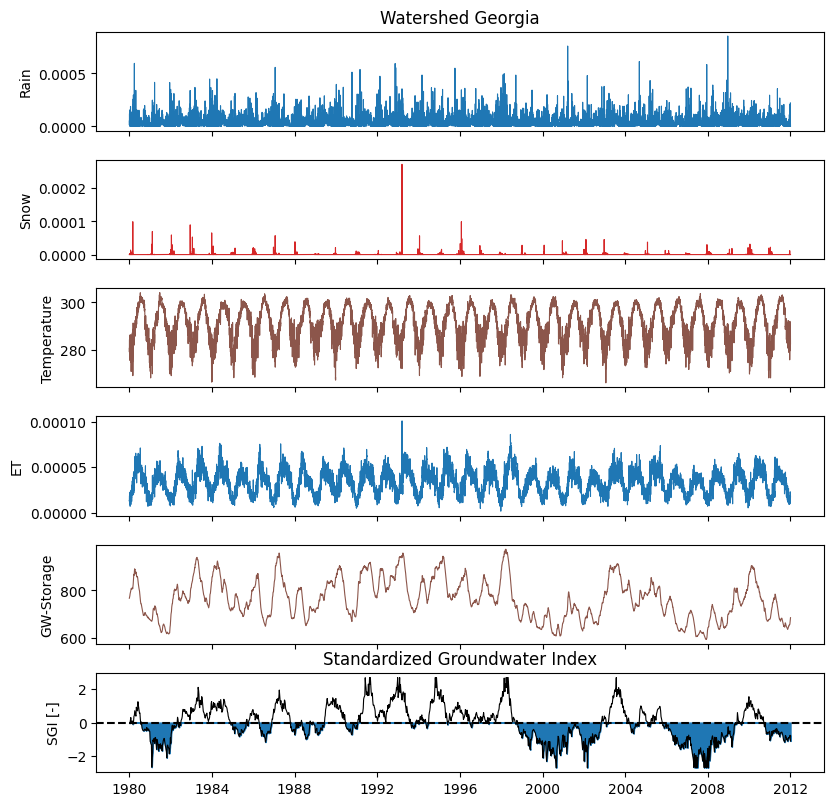

In [11]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(8, 8))
fig.tight_layout()

ax1.plot(hydrodata['Rain precipitation rate'],  'tab:blue', lw=0.8)
ax2.plot(hydrodata['Snow precipitation rate'], 'tab:red',  lw=0.8)
ax3.plot(hydrodata['Near surface air temperature'],  'tab:brown', lw=0.8)
ax4.plot(hydrodata['Evapotranspiration'],  'tab:blue', lw=0.8)
#ax5.plot(hydrodata['Plant canopy'],  'tab:red', lw=0.8)
ax5.plot(hydrodata['Groundwater storage'],  'tab:brown', lw=0.8)

ax1.set_title(f"Watershed {STATION_ID}")
ax1.set_ylabel("Rain")
ax2.set_ylabel("Snow")
ax3.set_ylabel("Temperature")
ax4.set_ylabel("ET")
#ax5.set_ylabel("Canopy")
ax5.set_ylabel("GW-Storage")
               
sgi = ps.stats.sgi(GWS.resample("W").mean())
# sgi.plot(ax=ax4, color="k")
ax6.plot(sgi, color = 'black', lw=0.8)
ax6.axhline(0, linestyle="--", color="k")
droughts = sgi.to_numpy(copy=True)
droughts[droughts > 0] = 0
ax6.fill_between(sgi.index, 0, droughts, color="C0")
ax6.set_ylabel("SGI [-]")
ax6.set_title("Standardized Groundwater Index");

plt.show()

In [13]:
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        data_x_dict, data_y_dict = pickle.load(f)
else:
    data_x_dict, data_y_dict = xdata.get_wrapped_data(dataset=hydrodata,  wrap_length=WRAP_LENGTH)
    with open(data_path, 'wb') as f:
        pickle.dump([data_x_dict, data_y_dict], f)


### Split data samples for training and testing


In [14]:
split_results = xdata.split_train_test(dataset=hydrodata, 
                                       data_x_dict=data_x_dict, 
                                       data_y_dict=data_y_dict, 
                                       frac=TRAIN_FRAC, 
                                       random_state=RANDOM_SEED, 
                                       scale=True)

train_dates, test_dates, x_train, y_train, x_test, y_test, scale_params = split_results

print(f'The shape of x_train, y_train after wrapping by {WRAP_LENGTH} days are {x_train.shape}, {y_train.shape}')
print(f'The shape of x_test, y_test after wrapping by {WRAP_LENGTH} days are   {x_test.shape}, {y_test.shape}')

The shape of x_train, y_train after wrapping by 180 days are (8056, 180, 5), (8056, 1)
The shape of x_test, y_test after wrapping by 180 days are   (3453, 180, 5), (3453, 1)


## 2. Model building and evaluation

In [28]:
inputs = layers.Input(x_train.shape[1:], name='input')
lstm   = layers.LSTM(units=16, name='lstm', 
                     kernel_regularizer=regularizers.l2(0.001), 
                     recurrent_regularizer=regularizers.l2(0.001))(inputs)
output = layers.Dense(units=1, name='dense', activation='linear', use_bias=False, 
                      kernel_regularizer=regularizers.l2(0.001))(lstm)

model  = models.Model(inputs, output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 180, 5)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1408      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 1,424
Trainable params: 1,424
Non-trainable params: 0
_________________________________________________________________


In [29]:
es     = callbacks.EarlyStopping(monitor='val_R2', mode='max', verbose=1, patience=30, 
                                 min_delta=0.01, restore_best_weights=True)
reduce = callbacks.ReduceLROnPlateau(monitor='val_R2', factor=0.5, patience=15, verbose=1, 
                                     mode='max', min_delta=0.01, cooldown=0, min_lr=LEARNING_RATE / 100)
tnan   = callbacks.TerminateOnNaN()

model.compile(loss='mse', metrics=[xutils.R2], optimizer=optimizers.Adam(lr=LEARNING_RATE))
model.fit(x_train, y_train, epochs=EPOCH_NUMBER, batch_size=1024, validation_split=0.3, 
          callbacks=[es, reduce, tnan])
model.save(model_path)

Train on 5639 samples, validate on 2417 samples
Epoch 1/100
5639/5639 [==============================] - 2s 412us/sample - loss: 0.7848 - R2: 0.2658 - val_loss: 0.5028 - val_R2: 0.5244
Epoch 2/100
5639/5639 [==============================] - 2s 266us/sample - loss: 0.4947 - R2: 0.5439 - val_loss: 0.4447 - val_R2: 0.5738
Epoch 3/100
5639/5639 [==============================] - 2s 277us/sample - loss: 0.4312 - R2: 0.6036 - val_loss: 0.4050 - val_R2: 0.6169
Epoch 4/100
5639/5639 [==============================] - 1s 263us/sample - loss: 0.3919 - R2: 0.6448 - val_loss: 0.3559 - val_R2: 0.6587
Epoch 5/100
5639/5639 [==============================] - 2s 277us/sample - loss: 0.3543 - R2: 0.6803 - val_loss: 0.3278 - val_R2: 0.7002
Epoch 6/100
5639/5639 [==============================] - 2s 266us/sample - loss: 0.3286 - R2: 0.7062 - val_loss: 0.2908 - val_R2: 0.7351
Epoch 7/100
5639/5639 [==============================] - 2s 289us/sample - loss: 0.3017 - R2: 0.7330 - val_loss: 0.2828 - val_R2: 

Epoch 59/100
5639/5639 [==============================] - 1s 251us/sample - loss: 0.0715 - R2: 0.9658 - val_loss: 0.0726 - val_R2: 0.9637
Epoch 60/100
5639/5639 [==============================] - 1s 250us/sample - loss: 0.0691 - R2: 0.9677 - val_loss: 0.0692 - val_R2: 0.9665
Epoch 61/100
5639/5639 [==============================] - 1s 254us/sample - loss: 0.0665 - R2: 0.9697 - val_loss: 0.0695 - val_R2: 0.9631
Epoch 62/100
5639/5639 [==============================] - 1s 259us/sample - loss: 0.0659 - R2: 0.9697 - val_loss: 0.0713 - val_R2: 0.9626
Epoch 63/100
5639/5639 [==============================] - 1s 260us/sample - loss: 0.0652 - R2: 0.9693 - val_loss: 0.0703 - val_R2: 0.9632
Epoch 64/100
5639/5639 [==============================] - 1s 244us/sample - loss: 0.0644 - R2: 0.9697 - val_loss: 0.0653 - val_R2: 0.9675
Epoch 65/100
5639/5639 [==============================] - 1s 258us/sample - loss: 0.0611 - R2: 0.9722 - val_loss: 0.0641 - val_R2: 0.9669
Epoch 66/100
5639/5639 [==========

In [30]:
eval_model = models.load_model(model_path, custom_objects={'R2': xutils.R2})
pred_train = eval_model.predict(x_train, batch_size=1024)
pred_test  = eval_model.predict(x_test, batch_size=1024)

print(f"NSE for the training data: {xutils.cal_nse(y_train, pred_train):.3f}")
print(f"NSE for the testing data:  {xutils.cal_nse(y_test, pred_test):.3f}")

NSE for the training data: 0.988
NSE for the testing data:  0.987


In [31]:
xutils.cal_nse(y_train, pred_train)

0.9875077919357957

In [32]:
hydrodata.loc[train_dates, ['flow_pred']] = pred_train * scale_params['train_y_std'] + scale_params['train_y_mean']
hydrodata.loc[test_dates,  ['flow_pred']] = pred_test  * scale_params['train_y_std'] + scale_params['train_y_mean']


## 3. Identify important groundwater drought events by SGI mothod

Identify Groundwater based on "sgi" from pastas function.

For more arguments, please see https://pastas.readthedocs.io/en/latest/examples/011_sgi_example.ipynb.html

### A glimpse of the identified drought events

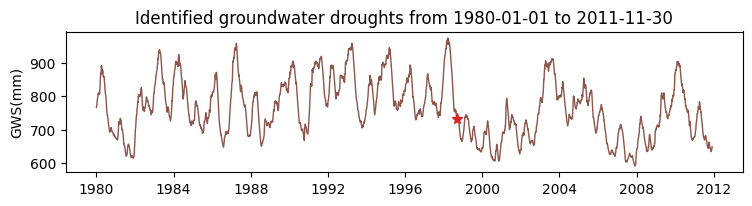

In [104]:
GD='1998-09-09'
Q=hydrodata
drought_dates = [f'{GD}']
plot_range=['1980-01-01', '2011-11-30']
linecolor="tab:brown"
markercolor="tab:red"
figsize=(7.5, 2.0)
fig, ax = plt.subplots(figsize=figsize)
fig.tight_layout()

plot_range[0] = Q.index[0] if plot_range[0] == None else plot_range[0]
plot_range[1] = Q.index[-1] if plot_range[1] == None else plot_range[1]

ax.plot(Q["GWS"].loc[plot_range[0]:plot_range[1]], color=linecolor, lw=1.0)
ax.plot(
    Q.loc[drought_dates, "GWS"].loc[plot_range[0]:plot_range[1]],
    "*",
    c=markercolor,
    markersize=8,
)

ax.set_title(f"Identified groundwater droughts from {plot_range[0]} to {plot_range[1]}")
ax.set_ylabel("GWS(mm)")

plt.show()


# 4. Interpret LSTM models by expected gradients

***For getting the feature importance scores for all the drought events:***

In [105]:
eval_x_dict  = dict((drought_date, data_x_dict[drought_date]) for drought_date in drought_dates if drought_date in data_x_dict)

***For getting the feature importance scores for a specific drought event:***

In [106]:
drought_date= GD

eval_x_dict  = dict((drought_date, data_x_dict[drought_date]) for drought_date in [pd.to_datetime(drought_date)] if drought_date in data_x_dict)

In [107]:
drought_eg_dict, drought_eg_var_dict = xinterpret.interpret_eg(model=eval_model, 
                                                         background=x_train, 
                                                         x_dict=eval_x_dict, 
                                                         scale_params=scale_params, 
                                                         path=eg_path, 
                                                         overwrite=True)

File exists in Desktop\GW_Drought\GRACE\Gulf of Mexico,North Atlantic Coast watershed\Timeseries\Subregions\Georgia\results\eg\Georgia_100_eg.pickle! Now overwrite the file.
You can set overwrite=False to reload the saved file.

Create a GradientExplainer and calculate EG values. Please be patient, it would take some time...


  0%|          | 0/1 [00:00<?, ?it/s]

Done! The file is saved to Desktop\GW_Drought\GRACE\Gulf of Mexico,North Atlantic Coast watershed\Timeseries\Subregions\Georgia\results\eg\Georgia_100_eg.pickle


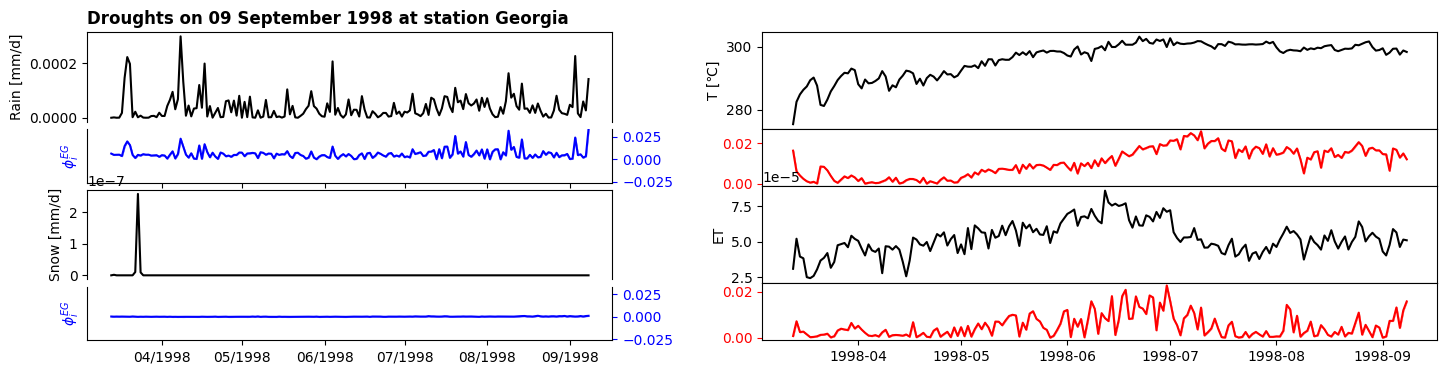

In [109]:
dataset=hydrodata
drought_eg_dict=drought_eg_dict
drought_eg_var_dict=drought_eg_var_dict 
drought_date=drought_date
title_suffix=f'at station {STATION_ID}'
linewidth=1.5
figsize=(15, 4)

eg_plot = dataset.loc[pd.date_range(end=drought_date, periods=list(drought_eg_dict.values())[0].shape[1]+1, freq='d')[:-1]]

eg_plot.loc[:, "Rainfall_eg"] = abs(drought_eg_dict[pd.to_datetime(drought_date)][0, :, 0])
eg_plot.loc[:, "Snowfall_eg"] = abs(drought_eg_dict[pd.to_datetime(drought_date)][0, :, 1])
eg_plot.loc[:, "tmean_eg"] = abs(drought_eg_dict[pd.to_datetime(drought_date)][0, :, 2])
eg_plot.loc[:, "ET_eg"] = abs(drought_eg_dict[pd.to_datetime(drought_date)][0, :, 3]) 
eg_plot.loc[:, "Rainfall_eg_val"] = abs(drought_eg_var_dict[pd.to_datetime(drought_date)][0, :, 0])
eg_plot.loc[:, "Snowfall_eg_val"] = abs(drought_eg_var_dict[pd.to_datetime(drought_date)][0, :, 1])
eg_plot.loc[:, "tmean_eg_val"] = abs(drought_eg_var_dict[pd.to_datetime(drought_date)][0, :, 2])
eg_plot.loc[:, "ET_eg_val"] = abs(drought_eg_var_dict[pd.to_datetime(drought_date)][0, :, 3])



fig = plt.figure(constrained_layout=False, figsize=figsize)

gs1 = fig.add_gridspec(nrows=4, ncols=1, hspace=0.1, left=0.1, right=0.45, height_ratios=[2.5,1.5,2.5,1.5])
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[1, 0])
ax3 = fig.add_subplot(gs1[2, 0])
ax4 = fig.add_subplot(gs1[3, 0])

gs2 = fig.add_gridspec(nrows=4, ncols=1, hspace=0, left=0.55, right=1, height_ratios=[2.5,1.5,2.5,1.5])
ax5 = fig.add_subplot(gs2[0, 0])
ax6 = fig.add_subplot(gs2[1, 0])
ax7 = fig.add_subplot(gs2[2, 0])
ax8 = fig.add_subplot(gs2[3, 0])

    

for ax in [ax1, ax3]:
    ax.spines["bottom"].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)

for ax in [ax2, ax4]:
    ax.set_ylabel(r'$\phi^{EG}_{i}$')
    ax.spines["top"].set_visible(False)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("left")
    ax.set_ylim(bottom=np.min(drought_eg_dict[pd.to_datetime(drought_date)]),
             top=np.max(drought_eg_dict[pd.to_datetime(drought_date)]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))


ax1.plot(eg_plot['Rainfall'], color='k', lw=linewidth)
ax1.set_ylabel('Rain [mm/d]', ha='center', y=0.5)

ax2.plot(eg_plot['Rainfall_eg'], color='blue', lw=linewidth)
ax2.fill_between(eg_plot['Rainfall_eg'].index,
                 eg_plot['Rainfall_eg']-eg_plot.loc[:, "Rainfall_eg_val"],
                 eg_plot['Rainfall_eg']+eg_plot.loc[:, "Rainfall_eg_val"], color='blue', alpha=0.3)
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

ax3.plot(eg_plot['Snowfall'], color='k', lw=linewidth)
ax3.set_ylabel('Snow [mm/d]', ha='center', y=0.5)

ax4.plot(eg_plot['Snowfall_eg'], color='blue', lw=linewidth)
ax4.fill_between(eg_plot['Snowfall_eg'].index,
                 eg_plot['Snowfall_eg']-eg_plot.loc[:, "Snowfall_eg_val"],
                 eg_plot['Snowfall_eg']+eg_plot.loc[:, "Snowfall_eg_val"], color='blue', alpha=0.3)
ax4.yaxis.label.set_color('blue')
ax4.tick_params(axis='y', colors='blue')
    
    
ax5.plot(eg_plot['tmean'], color='k', lw=linewidth)
ax5.set_ylabel('T [\u2103]', ha='center', y=0.5)

ax6.plot(eg_plot['tmean_eg'], color='red', lw=linewidth)
ax6.fill_between(eg_plot['tmean_eg'].index,
                 eg_plot['tmean_eg']-eg_plot.loc[:, "tmean_eg_val"],
                 eg_plot['tmean_eg']+eg_plot.loc[:, "tmean_eg_val"], color='red', alpha=0.3)
ax6.yaxis.label.set_color('red')
ax6.tick_params(axis='y', colors='red')
    
ax7.plot(eg_plot['ET'], color='k', lw=linewidth)
ax7.set_ylabel('ET', ha='center', y=0.5)    
    
ax8.plot(eg_plot['ET_eg'], color='red', lw=linewidth)
ax8.fill_between(eg_plot['ET_eg'].index,
                 eg_plot['ET_eg']-eg_plot.loc[:, "ET_eg_val"],
                 eg_plot['ET_eg']+eg_plot.loc[:, "ET_eg_val"], color='red', alpha=0.3)
ax8.yaxis.label.set_color('red')
ax8.tick_params(axis='y', colors='red')    

   
    

ax1.set_title(f"Droughts on {pd.to_datetime(drought_date).strftime('%d %B %Y')} {str(title_suffix)}",
                  fontweight='bold', loc='left')

plt.show()

## 5. Interpret LSTM models by additive decomposition

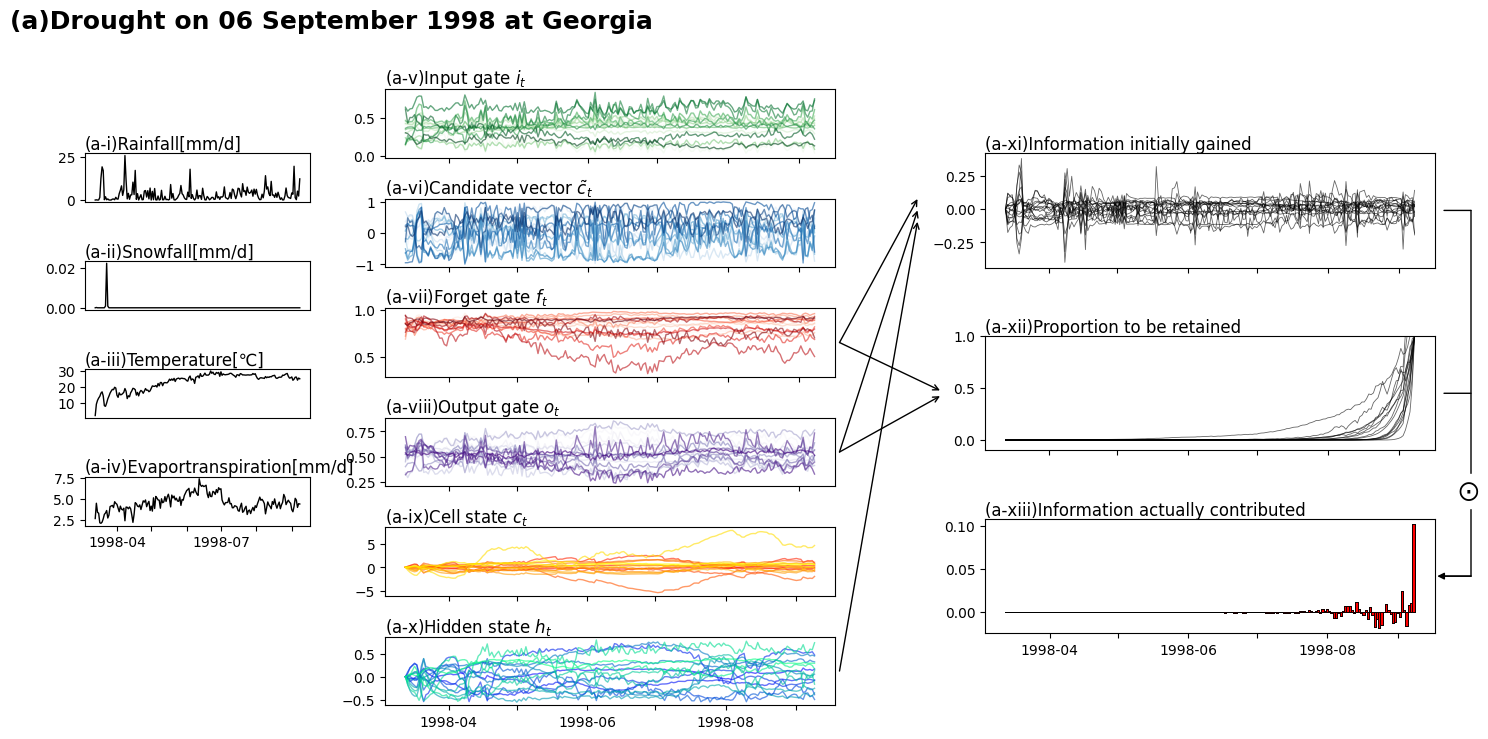

In [113]:
decomp_dict = xinterpret.interpret_decomp(eval_model).get_internals(eval_x_dict, scale_params=scale_params)
dataset=hydrodata
decomp_dict=decomp_dict
drought_date=drought_date
title_suffix=f'at {STATION_ID}'
linewidth=1.0
figsize=(15, 8)
def plot_arrow(a1, p1, a2, p2, coordsA='axes fraction', coordsB='axes fraction'):
    con = mpatches.ConnectionPatch(xyA=p1, xyB=p2, coordsA=coordsA, coordsB=coordsB,
                                   axesA=a1, axesB=a2, arrowstyle="-|>", facecolor='black')
    a1.add_artist(con)

def plot_simple_arrow(a1, p1, a2, p2, coordsA='axes fraction', coordsB='axes fraction'):
    con = mpatches.ConnectionPatch(xyA=p1, xyB=p2, coordsA=coordsA, coordsB=coordsB,
                                   axesA=a1, axesB=a2, arrowstyle="->", facecolor='black')
    a1.add_artist(con)

def plot_line(a1, p1, a2, p2, coordsA='axes fraction', coordsB='axes fraction'):
    con = mpatches.ConnectionPatch(xyA=p1, xyB=p2, coordsA=coordsA, coordsB=coordsB,
                                   axesA=a1, axesB=a2)
    a1.add_artist(con)
blue_colors   = mpl.cm.Blues(np.linspace(0,1,16))
green_colors  = mpl.cm.Greens(np.linspace(0,1,16))
red_colors    = mpl.cm.Reds(np.linspace(0,1,16))
purple_colors = mpl.cm.Purples(np.linspace(0,1,16))
winter_colors = mpl.cm.winter(np.linspace(0,1,16))
autumn_colors = mpl.cm.autumn(np.linspace(0,1,16))
decomp_plot = dataset.loc[pd.date_range(end=drought_date, periods=list(decomp_dict.values())[0]['x'].shape[0]+1, freq='d')]


fig = plt.figure(constrained_layout=False, figsize=figsize)

gs1 = fig.add_gridspec(nrows=5, ncols=1, hspace=1.2, left=0.050, right=0.20, top=0.80, bottom=0.20)
gs2 = fig.add_gridspec(nrows=6, ncols=1, hspace=0.6, left=0.250, right=0.550)
gs3 = fig.add_gridspec(nrows=3, ncols=1, hspace=0.6, left=0.650, right=0.950, top=0.80, bottom=0.20)

ax1_1 = fig.add_subplot(gs1[0, 0])
ax1_2 = fig.add_subplot(gs1[1, 0])
ax1_3 = fig.add_subplot(gs1[2, 0])
ax1_4 = fig.add_subplot(gs1[3, 0]) 
#ax1_5 = fig.add_subplot(gs1[4, 0])

ax2_1 = fig.add_subplot(gs2[0, 0])
ax2_2 = fig.add_subplot(gs2[1, 0])
ax2_3 = fig.add_subplot(gs2[2, 0])
ax2_4 = fig.add_subplot(gs2[3, 0])
ax2_5 = fig.add_subplot(gs2[4, 0])
ax2_6 = fig.add_subplot(gs2[5, 0])

ax3_1 = fig.add_subplot(gs3[0, 0])
ax3_2 = fig.add_subplot(gs3[1, 0])
ax3_3 = fig.add_subplot(gs3[2, 0])

ax1_1.plot(decomp_plot['Rainfall'].iloc[:-1]*86400, color='k', lw=linewidth)
ax1_2.plot(decomp_plot['Snowfall'].iloc[:-1]*86400, color='k', lw=linewidth)
ax1_3.plot(decomp_plot['tmean'].iloc[:-1]-273.15 , color='k', lw=linewidth)
ax1_4.plot(decomp_plot['ET'].iloc[:-1]*86400, color='k', lw=linewidth)


    
    
for i in range(16):
    ax2_1.plot(decomp_plot.index[:-1], decomp_dict[pd.to_datetime(drought_date)]['hi_arr'][:, i],
                   c=green_colors[i], alpha=0.60, lw=linewidth)
    ax2_2.plot(decomp_plot.index[:-1], decomp_dict[pd.to_datetime(drought_date)]['hc_arr'][:, i],
                   c=blue_colors[i], alpha=0.60, lw=linewidth)
    ax2_3.plot(decomp_plot.index[:-1], decomp_dict[pd.to_datetime(drought_date)]['hf_arr'][:, i],
                   c=red_colors[i], alpha=0.60, lw=linewidth)
    ax2_4.plot(decomp_plot.index[:-1], decomp_dict[pd.to_datetime(drought_date)]['ho_arr'][:, i],
                   c=purple_colors[i], alpha=0.60, lw=linewidth)
    ax2_5.plot(decomp_plot.index[:], decomp_dict[pd.to_datetime(drought_date)]['c_states'][:, i],
                   c=autumn_colors[i], alpha=0.60, lw=linewidth)
    ax2_6.plot(decomp_plot.index[:], decomp_dict[pd.to_datetime(drought_date)]['h_states'][:, i],
                   c=winter_colors[i], alpha=0.60, lw=linewidth)

    ax3_1.plot(decomp_plot.index[:-1], decomp_dict[pd.to_datetime(drought_date)]['h_update'][:, i],
                   c='#000', alpha=0.60, lw=linewidth*0.6)
    ax3_2.plot(decomp_plot.index[:-1], decomp_dict[pd.to_datetime(drought_date)]['h_forget'][:, i],
                   c='#000', alpha=0.60, lw=linewidth*0.6)

    ax3_3.bar(decomp_plot.index[:-1],
              np.matmul(decomp_dict[pd.to_datetime(drought_date)]['h_forget'][:] * decomp_dict[pd.to_datetime(drought_date)]['h_update'][:],
                        decomp_dict[pd.to_datetime(drought_date)]['dense_W'])[:, 0],
              edgecolor='k',
              width=np.timedelta64(1, 'D'),
              color='red',
              linewidth=0.6)

ax1_1.set_xticklabels([])
ax2_1.set_xticklabels([])
ax2_2.set_xticklabels([])
ax2_3.set_xticklabels([])
ax2_4.set_xticklabels([])
ax2_5.set_xticklabels([])
ax3_1.set_xticklabels([])
ax3_2.set_xticklabels([])

ax1_1.set_title('(a-i)Rainfall[mm/d]', loc='left', pad=0)  
ax1_2.set_title('(a-ii)Snowfall[mm/d]',loc='left', pad=0)
ax1_3.set_title('(a-iii)Temperature[\u2103]', loc='left', pad=0)  
ax1_4.set_title('(a-iv)Evaportranspiration[mm/d]',loc='left', pad=0)    
#ax1_5.set_title('Plant Canopy', loc='left', pad=0)  


#ax1_1.spines["bottom"].set_visible(False)
ax1_1.axes.get_xaxis().set_visible(False)
#ax1_2.spines["bottom"].set_visible(False)
ax1_2.axes.get_xaxis().set_visible(False)
#ax1_3.spines["bottom"].set_visible(False)
ax1_3.axes.get_xaxis().set_visible(False) 


ax2_1.set_title(r'(a-v)Input gate $i_t$', loc='left', pad=0)
ax2_2.set_title(r'(a-vi)Candidate vector $\tilde{c}_t$', loc='left', pad=0)
ax2_3.set_title(r'(a-vii)Forget gate $f_t$', loc='left', pad=0)
ax2_4.set_title(r'(a-viii)Output gate $o_t$', loc='left', pad=0)
ax2_5.set_title(r'(a-ix)Cell state $c_t$', loc='left', pad=0)
ax2_6.set_title(r'(a-x)Hidden state $h_t$', loc='left', pad=0)
ax3_1.set_title(r'(a-xi)Information initially gained', loc='left', pad=0)
ax3_2.set_title(r'(a-xii)Proportion to be retained', loc='left', pad=0)
ax3_3.set_title(r'(a-xiii)Information actually contributed', loc='left', pad=0)

ax1_4.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1_4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for tick in ax1_4.xaxis.get_ticklabels()[1:3] + ax1_4.xaxis.get_ticklabels()[4:6]:
        tick.set_visible(False)

ax2_6.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2_6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for tick in ax2_6.xaxis.get_ticklabels()[1::2]:
        tick.set_visible(False)

ax3_3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3_3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for tick in ax3_3.xaxis.get_ticklabels()[1::2]:
        tick.set_visible(False)

ax3_2.set_ylim(bottom=-0.1*np.percentile(decomp_dict[pd.to_datetime(drought_date)]['h_forget'][-1, :], q=0.75),
                   top=np.percentile(decomp_dict[pd.to_datetime(drought_date)]['h_forget'][-1, :], q=0.75))


plot_simple_arrow(ax2_3, (1.01, 0.5), ax3_1, (-0.15, 0.60))
plot_simple_arrow(ax2_4, (1.01, 0.5), ax3_1, (-0.15, 0.50))
plot_simple_arrow(ax2_6, (1.01, 0.5), ax3_1, (-0.15, 0.40))

plot_simple_arrow(ax2_3, (1.01, 0.5), ax3_2, (-0.10, 0.525))
plot_simple_arrow(ax2_4, (1.01, 0.5), ax3_2, (-0.10, 0.475))

plot_line(ax3_1, (1.02, 0.5), ax3_1, (1.08, 0.5))
plot_line(ax3_2, (1.02, 0.5), ax3_2, (1.08, 0.5))
plot_line(ax3_3, (1.02, 0.5), ax3_3, (1.08, 0.5))
plot_line(ax3_1, (1.08, 0.5), ax3_3, (1.08, 0.5))
plot_arrow(ax3_3, (1.08, 0.5), ax3_3, (1.005, 0.5))
ax3_2.annotate(r'$\bigodot$', (1.05, -0.4), xycoords='axes fraction', backgroundcolor='white')

fig.suptitle(f"(a)Drought on 06 September 1998 at Georgia",
                 fontweight='bold', fontsize =18, x=0, ha='left')

plt.show()